In [3]:
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import unquote

In [4]:
users_paths_df = pd.read_csv('../data2/paths_finished copie.csv' , sep = ';')
users_paths_df['path'] = users_paths_df['path'].apply(lambda x: x.split(';'))

#Decode from utf-8 all the name of the articles
users_paths_df['path'] = users_paths_df['path'].apply(lambda x: [unquote(i) for i in x])
users_paths_df['source'] = users_paths_df['path'].apply(lambda x: x[0] if x else None)
users_paths_df['target'] = users_paths_df['path'].apply(lambda x: x[-1] if x else None)
users_paths_df['path_length'] = users_paths_df['path'].apply(lambda x: len(x))

#Drop hashedIpAddress timestamp, duration_in_sec, and rating columns
users_paths_df = users_paths_df.drop(['hashedIpAddress','durationInSec', 'timestamp', 'rating'], axis=1)

users_paths_df

,path,source,target,path_length
0,"[14th_century, 15th_century, 16th_century, Pac...",14th_century,African_slave_trade,9
1,"[14th_century, Europe, Africa, Atlantic_slave_...",14th_century,African_slave_trade,5
2,"[14th_century, Niger, Nigeria, British_Empire,...",14th_century,African_slave_trade,8
3,"[14th_century, Renaissance, Ancient_Greece, Gr...",14th_century,Greece,4
4,"[14th_century, Italy, Roman_Catholic_Church, H...",14th_century,John_F._Kennedy,7
...,...,...,...,...
51290,"[Yagan, Ancient_Egypt, Civilization]",Yagan,Civilization,3
51291,"[Yagan, Folklore, Brothers_Grimm, <, 19th_cent...",Yagan,Fiction,9
51292,"[Yagan, Australia, England, France, United_Sta...",Yagan,U.S._Open_(tennis),7
51293,"[Yarralumla,_Australian_Capital_Territory, Aus...","Yarralumla,_Australian_Capital_Territory",Abraham_Lincoln,4


In [5]:
#Drop '<' in paths
users_paths_df['path'] = users_paths_df['path'].apply(lambda x: [i for i in x if i != '<'])

#Drop in paths, consecutive duplicates
users_paths_df['path'] = users_paths_df['path'].apply(lambda x: [x[i] for i in range(len(x)) if i == 0 or x[i] != x[i-1]])

users_paths_df

,path,source,target,path_length
0,"[14th_century, 15th_century, 16th_century, Pac...",14th_century,African_slave_trade,9
1,"[14th_century, Europe, Africa, Atlantic_slave_...",14th_century,African_slave_trade,5
2,"[14th_century, Niger, Nigeria, British_Empire,...",14th_century,African_slave_trade,8
3,"[14th_century, Renaissance, Ancient_Greece, Gr...",14th_century,Greece,4
4,"[14th_century, Italy, Roman_Catholic_Church, H...",14th_century,John_F._Kennedy,7
...,...,...,...,...
51290,"[Yagan, Ancient_Egypt, Civilization]",Yagan,Civilization,3
51291,"[Yagan, Folklore, Brothers_Grimm, 19th_century...",Yagan,Fiction,9
51292,"[Yagan, Australia, England, France, United_Sta...",Yagan,U.S._Open_(tennis),7
51293,"[Yarralumla,_Australian_Capital_Territory, Aus...","Yarralumla,_Australian_Capital_Territory",Abraham_Lincoln,4


In [6]:
links_df = pd.read_csv('../data2/file_names_links.csv')

In [7]:
train_df= users_paths_df.explode('path')

# Merge on the exploded 'path' (current page) and 'filename' to get 'source_links'
train_df = pd.merge(train_df, links_df, left_on='path', right_on='filename', how='left')

# Prepare to track the next page in the path; this might need correction based on your DataFrame structure
train_df['next_source'] = train_df.groupby(['source', 'target'])['path'].shift(-1)

# Use rename to adjust column names
train_df = train_df.rename(columns={
    'source': 'source',
    'path': 'current_page',
    'links': 'current_page_links',
    'next_source': 'next_page',
    'target': 'target'
})

# Select only the relevant columns to avoid KeyError
train_df = train_df[['source', 'target', 'current_page', 'current_page_links', 'next_page']].dropna()
train_df

,source,target,current_page,current_page_links,next_page
0,14th_century,African_slave_trade,14th_century,"['13th century', '15th century', 'India', 'Was...",15th_century
1,14th_century,African_slave_trade,15th_century,"['14th century', '16th century', 'Time', 'Timu...",16th_century
2,14th_century,African_slave_trade,16th_century,"['15th century', '17th century', 'Time', 'Braz...",Pacific_Ocean
3,14th_century,African_slave_trade,Pacific_Ocean,"['Earth', 'Ocean', 'Atlantic Ocean', 'Arctic O...",Atlantic_Ocean
4,14th_century,African_slave_trade,Atlantic_Ocean,"['Earth', 'Ocean', 'Arctic Ocean', 'Indian Oce...",Accra
...,...,...,...,...,...
324632,"Yarralumla,_Australian_Capital_Territory",Abraham_Lincoln,"Yarralumla,_Australian_Capital_Territory","['Canberra', 'Canberra', 'Australia', 'Lake Bu...",Australia
324633,"Yarralumla,_Australian_Capital_Territory",Abraham_Lincoln,Australia,"['Flag of Australia', 'Canberra', 'Sydney', 'E...",United_States
324634,"Yarralumla,_Australian_Capital_Territory",Abraham_Lincoln,United_States,"['Washington, D.C.', 'New York City', 'America...",Abraham_Lincoln
324636,Ziad_Jarrah,Jew,Ziad_Jarrah,"['Lebanon', 'United States', 'Arabic language'...",Germany


In [8]:
#Keep source 14th_century and target African_slave_trade
test = train_df[(train_df['source'] == '14th_century') & (train_df['target'] == 'African_slave_trade')]
test

,source,target,current_page,current_page_links,next_page
0,14th_century,African_slave_trade,14th_century,"['13th century', '15th century', 'India', 'Was...",15th_century
1,14th_century,African_slave_trade,15th_century,"['14th century', '16th century', 'Time', 'Timu...",16th_century
2,14th_century,African_slave_trade,16th_century,"['15th century', '17th century', 'Time', 'Braz...",Pacific_Ocean
3,14th_century,African_slave_trade,Pacific_Ocean,"['Earth', 'Ocean', 'Atlantic Ocean', 'Arctic O...",Atlantic_Ocean
4,14th_century,African_slave_trade,Atlantic_Ocean,"['Earth', 'Ocean', 'Arctic Ocean', 'Indian Oce...",Accra
5,14th_century,African_slave_trade,Accra,"['SOS Children in Tema, Accra', 'Time zone', '...",Africa
6,14th_century,African_slave_trade,Africa,"['SOS Children in Africa', 'Continent', 'Asia'...",Atlantic_slave_trade
7,14th_century,African_slave_trade,Atlantic_slave_trade,"['African American literature', 'Minstrel show...",African_slave_trade
8,14th_century,African_slave_trade,African_slave_trade,"['Atlantic slave trade', 'Ghana', 'Nigeria', '...",14th_century
9,14th_century,African_slave_trade,14th_century,"['13th century', '15th century', 'India', 'Was...",Europe


### Explore Data Analysis

In [9]:
links_df = pd.read_csv('../data2/file_names_links.csv')

In [10]:
links_df['node_outdegree'] = links_df['links'].apply(lambda x: len(x.split(',')) if type(x) == str else 0)
links_df

,filename,content,links,node_outdegree
0,10th_century,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...","['9th century', '11th century', 'Time', 'Dark ...",30
1,11th_century,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...","['10th century', '12th century', 'Time', 'Dark...",54
2,12th_century,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...","['11th century', '13th century', 'Time', 'Hung...",54
3,13th_century,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...","['12th century', '14th century', 'Time', 'Geng...",43
4,14th_century,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...","['13th century', '15th century', 'India', 'Was...",40
...,...,...,...,...
5404,Åland,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...","['List of countries by system of government', ...",27
5405,Édouard_Manet,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...","['Claude Monet', 'Paris', 'Paris', 'France', '...",29
5406,Éire,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...","['Ireland', 'English language', 'Ireland', 'Re...",12
5407,Óengus_I_of_the_Picts,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...","['Lion', 'Dál Riata', 'Scotland', 'Ireland', '...",12


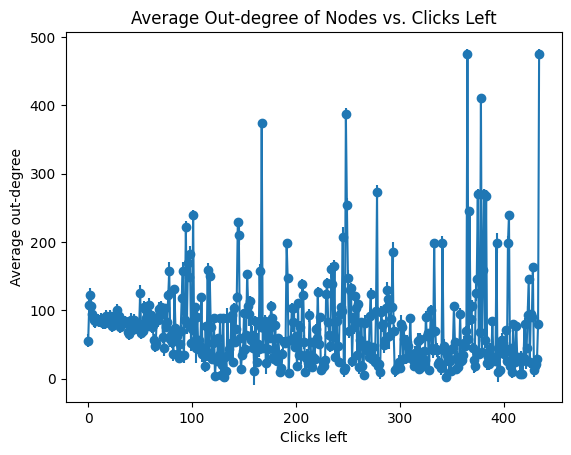

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data structure based on your description
# links_df = pd.DataFrame({'filename': ['page1', 'page2', 'page3', ...],
#                          'node_outdegree': [10, 20, 30, ...]})
# users_paths_df = pd.DataFrame({'source': ['source1', 'source2', 'source3', ...],
#                                'target': ['target1', 'target2', 'target3', ...],
#                                'path_length': [5, 6, 7, ...],
#                                'path': [['node1', 'node2', 'node3', ...], ...]})

# Dictionary to store total out-degrees and count for each position
outdegrees_by_position = {}

# Iterate over each user's path
for index, row in users_paths_df.iterrows():
    path = row['path']
    path_length = row['path_length']
    
    for position, node in enumerate(path):
        clicks_left = path_length - position - 1
        node_outdegree = links_df.loc[links_df['filename'] == node, 'node_outdegree'].values[0]
        
        if clicks_left not in outdegrees_by_position:
            outdegrees_by_position[clicks_left] = {'total_outdegree': 0, 'count': 0}
        
        outdegrees_by_position[clicks_left]['total_outdegree'] += node_outdegree
        outdegrees_by_position[clicks_left]['count'] += 1

# Calculate average out-degree for each position
average_outdegrees = {position: total['total_outdegree'] / total['count']
                      for position, total in outdegrees_by_position.items()}

# Sort the positions
sorted_positions = sorted(average_outdegrees.keys())

# Plotting
plt.errorbar(sorted_positions,
             [average_outdegrees[pos] for pos in sorted_positions],
             yerr=[(total['total_outdegree'] / total['count']) ** 0.5 for pos, total in outdegrees_by_position.items()],  # Example error calculation
             fmt='-o')

plt.xlabel('Clicks left')
plt.ylabel('Average out-degree')
plt.title('Average Out-degree of Nodes vs. Clicks Left')
plt.show()

In [12]:
outdegrees_by_position

{8: {'total_outdegree': 787324, 'count': 9305},
 7: {'total_outdegree': 1106173, 'count': 13146},
 6: {'total_outdegree': 1623610, 'count': 18884},
 5: {'total_outdegree': 2404197, 'count': 26823},
 4: {'total_outdegree': 3562694, 'count': 37456},
 3: {'total_outdegree': 4849429, 'count': 45543},
 2: {'total_outdegree': 5905295, 'count': 48071},
 1: {'total_outdegree': 5064137, 'count': 46839},
 0: {'total_outdegree': 2348538, 'count': 42303},
 12: {'total_outdegree': 259827, 'count': 3012},
 11: {'total_outdegree': 324023, 'count': 3849},
 10: {'total_outdegree': 425529, 'count': 5066},
 9: {'total_outdegree': 577411, 'count': 6738},
 15: {'total_outdegree': 131747, 'count': 1620},
 14: {'total_outdegree': 161237, 'count': 1968},
 13: {'total_outdegree': 205699, 'count': 2410},
 26: {'total_outdegree': 26740, 'count': 316},
 25: {'total_outdegree': 32260, 'count': 353},
 24: {'total_outdegree': 33954, 'count': 411},
 23: {'total_outdegree': 36169, 'count': 468},
 22: {'total_outdegree

In [15]:
#Plot the distribution of the length of the paths
import matplotlib.pyplot as plt
import seaborn as sns

users_paths_df['path_length'].describe()

count    51295.000000
mean         6.757345
std          4.681285
min          1.000000
25%          5.000000
50%          6.000000
75%          8.000000
max        435.000000
Name: path_length, dtype: float64